In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(1)
epochs = 512
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
76157,"[醫, 師, ：, 他, 有, 在, 騎, 腳, 踏, 車]","[O, O, O, O, O, O, O, O, O, O]"
76158,"[民, 眾, ：, 恩]","[O, O, O, O]"
76159,"[醫, 師, ：, 騎, 腳, 踏, 車, 可, 以]","[O, O, O, O, O, O, O, O, O]"
76160,"[小, 美]","[B-name, I-name]"


In [10]:
clinical_event = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/clinical_event.csv')
contact = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/contact.csv')
education = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/education.csv')
family = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/family.csv')
profession = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/profession.csv')

In [11]:
df = df.append(clinical_event)
df = df.append(contact)
df = df.append(education)
df = df.append(family)
df = df.append(profession)
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
495,"['那', '個', '時', '候', '是', '白', '天', '釣', '具', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-profess..."
496,"['因', '為', '我', '是', '還', '是', '網', '球', '球', ...","['O', 'O', 'O', 'O', 'O', 'O', 'B-profession',..."
497,"['醫', '師', '：', '你', '是', '採', '椰', '子', '工', ...","['O', 'O', 'O', 'O', 'O', 'B-profession', 'I-p..."
498,"['安', '養', '院', '工', '作', '人', '員']","['B-profession', 'I-profession', 'I-profession..."


In [12]:
df['x'] = df['x'].apply(lambda row : str(row))
df['y'] = df['y'].apply(lambda row : str(row))
df = df.drop_duplicates()
df['x'] = df['x'].apply(lambda row : eval(row))
df['y'] = df['y'].apply(lambda row : eval(row))
df

/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
495,"[那, 個, 時, 候, 是, 白, 天, 釣, 具, 製, 造, 工, 人]","[O, O, O, O, O, O, O, B-profession, I-professi..."
496,"[因, 為, 我, 是, 還, 是, 網, 球, 球, 員, 嘛]","[O, O, O, O, O, O, B-profession, I-profession,..."
497,"[醫, 師, ：, 你, 是, 採, 椰, 子, 工, 是, 不, 是]","[O, O, O, O, O, B-profession, I-profession, I-..."
498,"[安, 養, 院, 工, 作, 人, 員]","[B-profession, I-profession, I-profession, I-p..."


In [13]:
x = df['x'].to_list()
y = df['y'].to_list()

In [14]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

21571 21571
5393 5393
6742 6742


In [15]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-17 17:11:00,154 [DEBUG] kashgari - ------------------------------------------------
2020-12-17 17:11:00,155 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-17 17:11:00,155 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-17 17:11:00,156 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-17 17:11:00,156 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-17 17:11:00,156 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/512
21/21 [==============================] - 18s 871ms/step - loss: 4.8184 - accuracy: 0.8477 - val_loss: 28.9249 - val_accuracy: 0.9395
Epoch 2/512
21/21 [==============================] - 15s 715ms/step - loss: 1.7092 - accuracy: 0.9498 - val_loss: 28.6780 - val_accuracy: 0.9481
Epoch 3/512
21/21 [==============================] - 15s 695ms/step - loss: 1.1980 - accuracy: 0.9576 - val_loss: 28.4858 - val_accuracy: 0.9626
Epoch 4/512
21/21 [==============================] - 15s 698ms/step - loss: 0.9386 - accuracy: 0.9627 - val_loss: 28.4013 - val_accuracy: 0.9674
Epoch 5/512
21/21 [==============================] - 15s 702ms/step - loss: 0.7514 - accuracy: 0.9679 - val_loss: 28.3054 - val_accuracy: 0.9705
Epoch 6/512
21/21 [==============================] - 15s 703ms/step - loss: 0.6486 - accuracy: 0.9707 - val_loss: 28.2514 - val_accuracy: 0.9735
Epoch 7/512
21/21 [==============================] - 15s 705ms/step - loss: 0.5690 - accuracy: 0.9728 - val_loss: 28.0966 - val_ac

21/21 [==============================] - 15s 718ms/step - loss: 0.0676 - accuracy: 0.9962 - val_loss: 26.6653 - val_accuracy: 0.9861
Epoch 58/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0659 - accuracy: 0.9962 - val_loss: 26.5994 - val_accuracy: 0.9862
Epoch 59/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0607 - accuracy: 0.9967 - val_loss: 26.6461 - val_accuracy: 0.9864
Epoch 60/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0642 - accuracy: 0.9964 - val_loss: 26.5872 - val_accuracy: 0.9859
Epoch 61/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0611 - accuracy: 0.9967 - val_loss: 26.6011 - val_accuracy: 0.9863
Epoch 62/512
21/21 [==============================] - 15s 727ms/step - loss: 0.0571 - accuracy: 0.9968 - val_loss: 26.5534 - val_accuracy: 0.9861
Epoch 63/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0558 - accuracy: 0.9971 - val_loss: 26.5669 - val_accuracy

21/21 [==============================] - 15s 717ms/step - loss: 0.0266 - accuracy: 0.9984 - val_loss: 25.9311 - val_accuracy: 0.9768
Epoch 114/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0279 - accuracy: 0.9983 - val_loss: 25.8904 - val_accuracy: 0.9759
Epoch 115/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0302 - accuracy: 0.9981 - val_loss: 25.8411 - val_accuracy: 0.9744
Epoch 116/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0262 - accuracy: 0.9985 - val_loss: 25.8473 - val_accuracy: 0.9761
Epoch 117/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0249 - accuracy: 0.9986 - val_loss: 25.8272 - val_accuracy: 0.9762
Epoch 118/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0247 - accuracy: 0.9985 - val_loss: 25.8900 - val_accuracy: 0.9748
Epoch 119/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0263 - accuracy: 0.9984 - val_loss: 25.8611 - val_ac

Epoch 169/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0165 - accuracy: 0.9989 - val_loss: 25.1696 - val_accuracy: 0.9721
Epoch 170/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 25.1761 - val_accuracy: 0.9713
Epoch 171/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0184 - accuracy: 0.9988 - val_loss: 25.1753 - val_accuracy: 0.9706
Epoch 172/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0185 - accuracy: 0.9988 - val_loss: 25.0807 - val_accuracy: 0.9716
Epoch 173/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0191 - accuracy: 0.9985 - val_loss: 25.0708 - val_accuracy: 0.9723
Epoch 174/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0168 - accuracy: 0.9989 - val_loss: 25.1490 - val_accuracy: 0.9707
Epoch 175/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0184 - accuracy: 0.9985 - val_loss: 25

Epoch 225/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0151 - accuracy: 0.9986 - val_loss: 24.4714 - val_accuracy: 0.9623
Epoch 226/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 24.4690 - val_accuracy: 0.9615
Epoch 227/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0134 - accuracy: 0.9988 - val_loss: 24.4567 - val_accuracy: 0.9607
Epoch 228/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 24.4804 - val_accuracy: 0.9613
Epoch 229/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0135 - accuracy: 0.9989 - val_loss: 24.4081 - val_accuracy: 0.9599
Epoch 230/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0132 - accuracy: 0.9987 - val_loss: 24.3657 - val_accuracy: 0.9592
Epoch 231/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0157 - accuracy: 0.9986 - val_loss: 24

Epoch 281/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0116 - accuracy: 0.9990 - val_loss: 23.6468 - val_accuracy: 0.9458
Epoch 282/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0117 - accuracy: 0.9988 - val_loss: 23.6039 - val_accuracy: 0.9472
Epoch 283/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 23.6083 - val_accuracy: 0.9472
Epoch 284/512
21/21 [==============================] - 15s 715ms/step - loss: 0.0108 - accuracy: 0.9990 - val_loss: 23.5793 - val_accuracy: 0.9491
Epoch 285/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0113 - accuracy: 0.9989 - val_loss: 23.5758 - val_accuracy: 0.9453
Epoch 286/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0099 - accuracy: 0.9992 - val_loss: 23.6238 - val_accuracy: 0.9495
Epoch 287/512
21/21 [==============================] - 16s 742ms/step - loss: 0.0094 - accuracy: 0.9991 - val_loss: 23

Epoch 337/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 22.5807 - val_accuracy: 0.9388
Epoch 338/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0093 - accuracy: 0.9991 - val_loss: 22.5938 - val_accuracy: 0.9368
Epoch 339/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0100 - accuracy: 0.9989 - val_loss: 22.5594 - val_accuracy: 0.9380
Epoch 340/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 22.6030 - val_accuracy: 0.9323
Epoch 341/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 22.5380 - val_accuracy: 0.9421
Epoch 342/512
21/21 [==============================] - 15s 719ms/step - loss: 0.0102 - accuracy: 0.9988 - val_loss: 22.4979 - val_accuracy: 0.9300
Epoch 343/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0094 - accuracy: 0.9990 - val_loss: 22

Epoch 393/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 21.7358 - val_accuracy: 0.9343
Epoch 394/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 21.7268 - val_accuracy: 0.9370
Epoch 395/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0083 - accuracy: 0.9991 - val_loss: 21.7090 - val_accuracy: 0.9352
Epoch 396/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 21.6565 - val_accuracy: 0.9359
Epoch 397/512
21/21 [==============================] - 16s 744ms/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 21.6551 - val_accuracy: 0.9348
Epoch 398/512
21/21 [==============================] - 16s 742ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 21.6496 - val_accuracy: 0.9341
Epoch 399/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 21

Epoch 449/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 20.9224 - val_accuracy: 0.9240
Epoch 450/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 20.8883 - val_accuracy: 0.9241
Epoch 451/512
21/21 [==============================] - 15s 717ms/step - loss: 0.0106 - accuracy: 0.9987 - val_loss: 20.8614 - val_accuracy: 0.9240
Epoch 452/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 20.8119 - val_accuracy: 0.9259
Epoch 453/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0090 - accuracy: 0.9990 - val_loss: 20.8274 - val_accuracy: 0.9271
Epoch 454/512
21/21 [==============================] - 15s 716ms/step - loss: 0.0081 - accuracy: 0.9990 - val_loss: 20.7709 - val_accuracy: 0.9248
Epoch 455/512
21/21 [==============================] - 15s 718ms/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 20

Epoch 505/512
21/21 [==============================] - 15s 719ms/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 19.9741 - val_accuracy: 0.7298
Epoch 506/512
21/21 [==============================] - 15s 719ms/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 20.0133 - val_accuracy: 0.6643
Epoch 507/512
21/21 [==============================] - 16s 746ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 19.9781 - val_accuracy: 0.6630
Epoch 508/512
21/21 [==============================] - 16s 746ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 19.9853 - val_accuracy: 0.5316
Epoch 509/512
21/21 [==============================] - 15s 719ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 19.9516 - val_accuracy: 0.4105
Epoch 510/512
21/21 [==============================] - 15s 720ms/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 19.9762 - val_accuracy: 0.3287
Epoch 511/512
21/21 [==============================] - 15s 721ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 19

In [16]:
model.evaluate(test_x, test_y)
model_path = 'model/augmentation_{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-17 19:25:27,618 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-17 19:25:27,664 [DEBUG] kashgari - predict seq_length: None, input: (2, 6742, 72)


211/211 [==============================] - 19s 89ms/step


2020-12-17 19:25:49,799 [DEBUG] kashgari - predict output: (6742, 72)
2020-12-17 19:25:49,799 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.6709    0.7053    0.6877       526
clinical_event     0.9438    0.9545    0.9492        88
        family     0.8909    0.9703    0.9289       101
      med_exam     0.8539    0.7525    0.8000       101
    profession     0.9388    0.9020    0.9200       102
     education     0.9902    1.0000    0.9951       101
       contact     0.9130    0.7636    0.8317        55
      location     0.8814    0.8000    0.8387        65
          name     0.7925    0.7925    0.7925        53
         money     0.6000    0.7059    0.6486        17
            ID     0.5000    0.5000    0.5000         4
  organization     0.0000    0.0000    0.0000         1
        others     1.0000    0.5000    0.6667         2

     micro avg     0.7949    0.8002    0.7975      1216
     macro avg     0.7990    0.8002    0.7984      1216



2020-12-17 19:25:58,319 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/danny/bert/model/augmentation_bert-chinese_epoch_512_batch_1024


'/home/Danny/AI-CUP-2020/danny/bert/model/augmentation_bert-chinese_epoch_512_batch_1024'

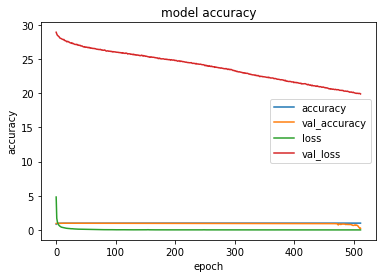

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [18]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [19]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [20]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [21]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-17 19:25:58,747 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 21ms/step


2020-12-17 19:26:01,847 [DEBUG] kashgari - predict output: (70, 17)
2020-12-17 19:26:01,848 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:01,850 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 34ms/step


2020-12-17 19:26:05,112 [DEBUG] kashgari - predict output: (131, 28)
2020-12-17 19:26:05,113 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:05,116 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 54ms/step


2020-12-17 19:26:09,031 [DEBUG] kashgari - predict output: (198, 47)
2020-12-17 19:26:09,032 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 19:26:09,034 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 36ms/step


2020-12-17 19:26:11,322 [DEBUG] kashgari - predict output: (96, 41)
2020-12-17 19:26:11,323 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:11,325 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 21ms/step


2020-12-17 19:26:11,442 [DEBUG] kashgari - predict output: (73, 17)
2020-12-17 19:26:11,443 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1 18 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 12  6 ...  6  6  6]
 [ 0  1  0 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:26:11,447 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 35ms/step


2020-12-17 19:26:14,823 [DEBUG] kashgari - predict output: (266, 23)
2020-12-17 19:26:14,824 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 19:26:14,827 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 36ms/step


2020-12-17 19:26:18,116 [DEBUG] kashgari - predict output: (308, 21)
2020-12-17 19:26:18,116 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1 10 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:26:18,118 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 42ms/step


2020-12-17 19:26:21,382 [DEBUG] kashgari - predict output: (139, 38)
2020-12-17 19:26:21,382 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:21,385 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 29ms/step


2020-12-17 19:26:24,567 [DEBUG] kashgari - predict output: (167, 22)
2020-12-17 19:26:24,567 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:24,572 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 51ms/step


2020-12-17 19:26:28,471 [DEBUG] kashgari - predict output: (272, 41)
2020-12-17 19:26:28,472 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 14 14 14]
 [ 0 20  7 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:26:28,475 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 63ms/step


2020-12-17 19:26:31,820 [DEBUG] kashgari - predict output: (143, 63)
2020-12-17 19:26:31,821 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:31,827 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 54ms/step


2020-12-17 19:26:36,042 [DEBUG] kashgari - predict output: (663, 42)
2020-12-17 19:26:36,042 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:36,044 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 15ms/step


2020-12-17 19:26:39,161 [DEBUG] kashgari - predict output: (39, 25)
2020-12-17 19:26:39,163 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  

6/6 [==============================] - 0s 31ms/step


2020-12-17 19:26:39,417 [DEBUG] kashgari - predict output: (175, 22)
2020-12-17 19:26:39,418 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:39,421 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 32ms/step


2020-12-17 19:26:39,642 [DEBUG] kashgari - predict output: (143, 28)
2020-12-17 19:26:39,642 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:39,645 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 21ms/step


2020-12-17 19:26:39,765 [DEBUG] kashgari - predict output: (88, 21)
2020-12-17 19:26:39,766 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:39,769 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 30ms/step


2020-12-17 19:26:39,955 [DEBUG] kashgari - predict output: (121, 28)
2020-12-17 19:26:39,956 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:39,958 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-17 19:26:43,055 [DEBUG] kashgari - predict output: (85, 27)
2020-12-17 19:26:43,056 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:43,059 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 34ms/step


2020-12-17 19:26:46,437 [DEBUG] kashgari - predict output: (255, 19)
2020-12-17 19:26:46,438 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:46,441 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 38ms/step


2020-12-17 19:26:50,252 [DEBUG] kashgari - predict output: (202, 29)
2020-12-17 19:26:50,253 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:50,255 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 28ms/step


2020-12-17 19:26:50,502 [DEBUG] kashgari - predict output: (198, 19)
2020-12-17 19:26:50,503 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 16 16 16]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:26:50,505 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 39ms/step


2020-12-17 19:26:53,635 [DEBUG] kashgari - predict output: (102, 39)
2020-12-17 19:26:53,635 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:53,636 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 29ms/step


2020-12-17 19:26:56,749 [DEBUG] kashgari - predict output: (72, 36)
2020-12-17 19:26:56,750 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:56,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 36ms/step


2020-12-17 19:26:57,114 [DEBUG] kashgari - predict output: (246, 27)
2020-12-17 19:26:57,115 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:26:57,116 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 25ms/step


2020-12-17 19:27:00,202 [DEBUG] kashgari - predict output: (57, 34)
2020-12-17 19:27:00,202 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:00,204 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-17 19:27:00,344 [DEBUG] kashgari - predict output: (82, 21)
2020-12-17 19:27:00,345 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:00,348 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 42ms/step


2020-12-17 19:27:03,718 [DEBUG] kashgari - predict output: (185, 32)
2020-12-17 19:27:03,718 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:03,721 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 32ms/step


2020-12-17 19:27:03,942 [DEBUG] kashgari - predict output: (148, 28)
2020-12-17 19:27:03,942 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:03,945 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 33ms/step


2020-12-17 19:27:04,308 [DEBUG] kashgari - predict output: (281, 23)
2020-12-17 19:27:04,308 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:04,310 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 27ms/step


2020-12-17 19:27:07,517 [DEBUG] kashgari - predict output: (116, 20)
2020-12-17 19:27:07,518 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:07,521 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 33ms/step


2020-12-17 19:27:07,782 [DEBUG] kashgari - predict output: (168, 25)
2020-12-17 19:27:07,783 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  4  2 ...  1  1  1]
 ...
 [ 0 12  6 ...  6  6  6]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:07,786 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 42ms/step


2020-12-17 19:27:11,237 [DEBUG] kashgari - predict output: (218, 30)
2020-12-17 19:27:11,238 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:11,240 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 33ms/step


2020-12-17 19:27:11,439 [DEBUG] kashgari - predict output: (123, 32)
2020-12-17 19:27:11,440 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:11,442 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 22ms/step


2020-12-17 19:27:11,564 [DEBUG] kashgari - predict output: (82, 21)
2020-12-17 19:27:11,565 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:11,567 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 22ms/step


2020-12-17 19:27:11,688 [DEBUG] kashgari - predict output: (95, 19)
2020-12-17 19:27:11,689 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:11,693 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 36ms/step


2020-12-17 19:27:15,074 [DEBUG] kashgari - predict output: (245, 24)
2020-12-17 19:27:15,075 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 4 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:15,077 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 37ms/step


2020-12-17 19:27:19,016 [DEBUG] kashgari - predict output: (126, 31)
2020-12-17 19:27:19,017 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 12  6 ...  8  8  8]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1 15 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:19,018 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 14ms/step


2020-12-17 19:27:21,271 [DEBUG] kashgari - predict output: (64, 19)
2020-12-17 19:27:21,271 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:21,273 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 28ms/step


2020-12-17 19:27:21,421 [DEBUG] kashgari - predict output: (93, 24)
2020-12-17 19:27:21,422 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:21,426 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 28ms/step


2020-12-17 19:27:24,727 [DEBUG] kashgari - predict output: (214, 16)
2020-12-17 19:27:24,727 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:24,729 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 16ms/step


2020-12-17 19:27:24,824 [DEBUG] kashgari - predict output: (53, 20)
2020-12-17 19:27:24,825 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:24,830 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 24ms/step


2020-12-17 19:27:27,301 [DEBUG] kashgari - predict output: (384, 18)
2020-12-17 19:27:27,302 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:27,304 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 28ms/step


2020-12-17 19:27:27,529 [DEBUG] kashgari - predict output: (172, 24)
2020-12-17 19:27:27,529 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:27,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 26ms/step


2020-12-17 19:27:27,690 [DEBUG] kashgari - predict output: (114, 24)
2020-12-17 19:27:27,691 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:27,693 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 42ms/step


2020-12-17 19:27:27,946 [DEBUG] kashgari - predict output: (111, 47)
2020-12-17 19:27:27,946 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:27,951 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 0s 42ms/step


2020-12-17 19:27:28,477 [DEBUG] kashgari - predict output: (350, 34)
2020-12-17 19:27:28,477 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:28,478 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 15ms/step


2020-12-17 19:27:28,558 [DEBUG] kashgari - predict output: (56, 20)
2020-12-17 19:27:28,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:28,561 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 25ms/step


2020-12-17 19:27:28,739 [DEBUG] kashgari - predict output: (131, 17)
2020-12-17 19:27:28,740 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:28,744 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 38ms/step


2020-12-17 19:27:29,045 [DEBUG] kashgari - predict output: (184, 34)
2020-12-17 19:27:29,046 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:29,049 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 51ms/step


2020-12-17 19:27:32,417 [DEBUG] kashgari - predict output: (133, 51)
2020-12-17 19:27:32,418 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:32,422 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 58ms/step


2020-12-17 19:27:36,043 [DEBUG] kashgari - predict output: (210, 53)
2020-12-17 19:27:36,044 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 14 14 14]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:36,047 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 57ms/step


2020-12-17 19:27:39,721 [DEBUG] kashgari - predict output: (193, 55)
2020-12-17 19:27:39,722 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 18 14 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:39,723 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 24ms/step


2020-12-17 19:27:39,856 [DEBUG] kashgari - predict output: (75, 30)
2020-12-17 19:27:39,857 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:39,861 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 58ms/step


2020-12-17 19:27:43,597 [DEBUG] kashgari - predict output: (280, 46)
2020-12-17 19:27:43,598 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:43,603 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 30ms/step


2020-12-17 19:27:43,868 [DEBUG] kashgari - predict output: (210, 20)
2020-12-17 19:27:43,868 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:43,873 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 31ms/step


2020-12-17 19:27:44,113 [DEBUG] kashgari - predict output: (176, 24)
2020-12-17 19:27:44,114 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:44,118 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 32ms/step


2020-12-17 19:27:44,401 [DEBUG] kashgari - predict output: (218, 25)
2020-12-17 19:27:44,402 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:44,404 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 24ms/step


2020-12-17 19:27:44,541 [DEBUG] kashgari - predict output: (91, 23)
2020-12-17 19:27:44,542 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:44,545 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 33ms/step


2020-12-17 19:27:44,840 [DEBUG] kashgari - predict output: (194, 28)
2020-12-17 19:27:44,841 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 8 8 8]
 ...
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:44,844 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 31ms/step


2020-12-17 19:27:45,089 [DEBUG] kashgari - predict output: (179, 23)
2020-12-17 19:27:45,089 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:45,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 49ms/step


2020-12-17 19:27:48,582 [DEBUG] kashgari - predict output: (234, 40)
2020-12-17 19:27:48,582 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:48,585 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 38ms/step


2020-12-17 19:27:51,973 [DEBUG] kashgari - predict output: (250, 26)
2020-12-17 19:27:51,973 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:51,978 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 47ms/step


2020-12-17 19:27:55,372 [DEBUG] kashgari - predict output: (170, 43)
2020-12-17 19:27:55,372 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:55,375 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 37ms/step


2020-12-17 19:27:55,630 [DEBUG] kashgari - predict output: (145, 34)
2020-12-17 19:27:55,630 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:55,633 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 28ms/step


2020-12-17 19:27:55,809 [DEBUG] kashgari - predict output: (102, 29)
2020-12-17 19:27:55,810 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:55,814 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 30ms/step


2020-12-17 19:27:56,205 [DEBUG] kashgari - predict output: (340, 20)
2020-12-17 19:27:56,206 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:56,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 28ms/step


2020-12-17 19:27:56,377 [DEBUG] kashgari - predict output: (122, 23)
2020-12-17 19:27:56,378 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:56,384 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 0s 38ms/step


2020-12-17 19:27:56,905 [DEBUG] kashgari - predict output: (381, 28)
2020-12-17 19:27:56,906 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:56,909 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 34ms/step


2020-12-17 19:27:57,243 [DEBUG] kashgari - predict output: (244, 27)
2020-12-17 19:27:57,244 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:57,246 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 40ms/step


2020-12-17 19:27:57,453 [DEBUG] kashgari - predict output: (91, 46)
2020-12-17 19:27:57,454 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:57,457 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 46ms/step


2020-12-17 19:27:57,856 [DEBUG] kashgari - predict output: (223, 42)
2020-12-17 19:27:57,857 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:57,859 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 29ms/step


2020-12-17 19:27:58,067 [DEBUG] kashgari - predict output: (146, 25)
2020-12-17 19:27:58,068 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:58,071 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 29ms/step


2020-12-17 19:27:58,309 [DEBUG] kashgari - predict output: (162, 23)
2020-12-17 19:27:58,309 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:27:58,313 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 35ms/step


2020-12-17 19:27:58,655 [DEBUG] kashgari - predict output: (244, 27)
2020-12-17 19:27:58,655 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 18 14 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  0  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:27:58,658 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 28ms/step


2020-12-17 19:28:02,783 [DEBUG] kashgari - predict output: (170, 18)
2020-12-17 19:28:02,784 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:02,788 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 39ms/step


2020-12-17 19:28:03,145 [DEBUG] kashgari - predict output: (199, 36)
2020-12-17 19:28:03,146 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:03,152 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 30ms/step


2020-12-17 19:28:03,750 [DEBUG] kashgari - predict output: (557, 17)
2020-12-17 19:28:03,751 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0 18 14 ... 14 14 14]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:03,754 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 48ms/step


2020-12-17 19:28:04,262 [DEBUG] kashgari - predict output: (278, 42)
2020-12-17 19:28:04,263 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:04,265 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 21ms/step


2020-12-17 19:28:04,383 [DEBUG] kashgari - predict output: (91, 19)
2020-12-17 19:28:04,384 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:04,389 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 35ms/step


2020-12-17 19:28:04,798 [DEBUG] kashgari - predict output: (296, 24)
2020-12-17 19:28:04,799 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:04,802 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 54ms/step


2020-12-17 19:28:08,211 [DEBUG] kashgari - predict output: (154, 48)
2020-12-17 19:28:08,212 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:08,217 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 47ms/step


2020-12-17 19:28:11,719 [DEBUG] kashgari - predict output: (206, 37)
2020-12-17 19:28:11,720 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1 18 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:11,724 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 30ms/step


2020-12-17 19:28:12,019 [DEBUG] kashgari - predict output: (241, 20)
2020-12-17 19:28:12,020 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:12,026 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 40ms/step


2020-12-17 19:28:12,711 [DEBUG] kashgari - predict output: (459, 31)
2020-12-17 19:28:12,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:12,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 40ms/step


2020-12-17 19:28:13,061 [DEBUG] kashgari - predict output: (223, 34)
2020-12-17 19:28:13,062 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:13,070 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 36ms/step


2020-12-17 19:28:13,574 [DEBUG] kashgari - predict output: (358, 26)
2020-12-17 19:28:13,574 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:13,576 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 20ms/step


2020-12-17 19:28:13,695 [DEBUG] kashgari - predict output: (72, 20)
2020-12-17 19:28:13,696 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:13,698 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 23ms/step


2020-12-17 19:28:13,832 [DEBUG] kashgari - predict output: (75, 24)
2020-12-17 19:28:13,833 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:13,837 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 42ms/step


2020-12-17 19:28:14,168 [DEBUG] kashgari - predict output: (191, 36)
2020-12-17 19:28:14,169 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:14,171 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 27ms/step


2020-12-17 19:28:14,358 [DEBUG] kashgari - predict output: (149, 19)
2020-12-17 19:28:14,359 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  8  8  8]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:14,362 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 30ms/step


2020-12-17 19:28:14,599 [DEBUG] kashgari - predict output: (176, 22)
2020-12-17 19:28:14,600 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 20  7 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:14,603 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 48ms/step


2020-12-17 19:28:18,081 [DEBUG] kashgari - predict output: (112, 45)
2020-12-17 19:28:18,082 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:18,087 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 31ms/step


2020-12-17 19:28:18,425 [DEBUG] kashgari - predict output: (269, 21)
2020-12-17 19:28:18,426 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:18,428 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 23ms/step


2020-12-17 19:28:18,574 [DEBUG] kashgari - predict output: (112, 18)
2020-12-17 19:28:18,575 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 4 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:18,581 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 27ms/step


2020-12-17 19:28:21,126 [DEBUG] kashgari - predict output: (352, 22)
2020-12-17 19:28:21,127 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:21,130 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 33ms/step


2020-12-17 19:28:21,454 [DEBUG] kashgari - predict output: (243, 24)
2020-12-17 19:28:21,455 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0 12  6 ...  6  6  6]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:21,458 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 36ms/step


2020-12-17 19:28:21,917 [DEBUG] kashgari - predict output: (340, 27)
2020-12-17 19:28:21,918 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:21,922 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 30ms/step


2020-12-17 19:28:24,435 [DEBUG] kashgari - predict output: (384, 25)
2020-12-17 19:28:24,436 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:24,438 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 34ms/step


2020-12-17 19:28:24,640 [DEBUG] kashgari - predict output: (112, 36)
2020-12-17 19:28:24,641 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:24,643 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 35ms/step


2020-12-17 19:28:24,960 [DEBUG] kashgari - predict output: (222, 28)
2020-12-17 19:28:24,961 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:24,964 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 42ms/step


2020-12-17 19:28:25,368 [DEBUG] kashgari - predict output: (255, 34)
2020-12-17 19:28:25,369 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:25,370 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 21ms/step


2020-12-17 19:28:25,489 [DEBUG] kashgari - predict output: (67, 25)
2020-12-17 19:28:25,490 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:25,491 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 36ms/step


2020-12-17 19:28:25,685 [DEBUG] kashgari - predict output: (77, 53)
2020-12-17 19:28:25,685 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:25,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 24ms/step


2020-12-17 19:28:25,812 [DEBUG] kashgari - predict output: (67, 27)
2020-12-17 19:28:25,813 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:25,814 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 20ms/step


2020-12-17 19:28:25,925 [DEBUG] kashgari - predict output: (72, 19)
2020-12-17 19:28:25,926 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:25,927 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 26ms/step


2020-12-17 19:28:26,094 [DEBUG] kashgari - predict output: (98, 24)
2020-12-17 19:28:26,094 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:26,096 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 31ms/step


2020-12-17 19:28:26,262 [DEBUG] kashgari - predict output: (87, 37)
2020-12-17 19:28:26,262 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:26,267 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 38ms/step


2020-12-17 19:28:26,713 [DEBUG] kashgari - predict output: (311, 29)
2020-12-17 19:28:26,714 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:26,721 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 0s 31ms/step


2020-12-17 19:28:27,214 [DEBUG] kashgari - predict output: (447, 20)
2020-12-17 19:28:27,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:27,218 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 28ms/step


2020-12-17 19:28:27,467 [DEBUG] kashgari - predict output: (218, 19)
2020-12-17 19:28:27,468 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:27,472 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 37ms/step


2020-12-17 19:28:27,867 [DEBUG] kashgari - predict output: (285, 30)
2020-12-17 19:28:27,868 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 8 8 8]
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:27,872 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 0s 32ms/step


2020-12-17 19:28:28,376 [DEBUG] kashgari - predict output: (424, 21)
2020-12-17 19:28:28,377 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:28,379 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 28ms/step


2020-12-17 19:28:28,525 [DEBUG] kashgari - predict output: (94, 30)
2020-12-17 19:28:28,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:28,530 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 38ms/step


2020-12-17 19:28:28,869 [DEBUG] kashgari - predict output: (202, 34)
2020-12-17 19:28:28,869 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:28,871 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 0s 59ms/step


2020-12-17 19:28:32,409 [DEBUG] kashgari - predict output: (242, 50)
2020-12-17 19:28:32,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 19:28:32,413 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 45ms/step


2020-12-17 19:28:32,891 [DEBUG] kashgari - predict output: (269, 38)
2020-12-17 19:28:32,892 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:32,894 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 35ms/step


2020-12-17 19:28:36,155 [DEBUG] kashgari - predict output: (108, 35)
2020-12-17 19:28:36,156 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:36,159 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 34ms/step


2020-12-17 19:28:36,400 [DEBUG] kashgari - predict output: (136, 30)
2020-12-17 19:28:36,400 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:36,403 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 35ms/step


2020-12-17 19:28:36,711 [DEBUG] kashgari - predict output: (217, 28)
2020-12-17 19:28:36,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:36,713 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 24ms/step


2020-12-17 19:28:36,845 [DEBUG] kashgari - predict output: (83, 27)
2020-12-17 19:28:36,845 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:36,849 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 43ms/step


2020-12-17 19:28:37,491 [DEBUG] kashgari - predict output: (392, 36)
2020-12-17 19:28:37,491 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:37,494 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 36ms/step


2020-12-17 19:28:37,711 [DEBUG] kashgari - predict output: (108, 41)
2020-12-17 19:28:37,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:37,716 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 34ms/step


2020-12-17 19:28:38,018 [DEBUG] kashgari - predict output: (221, 26)
2020-12-17 19:28:38,018 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:38,021 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 40ms/step


2020-12-17 19:28:38,223 [DEBUG] kashgari - predict output: (94, 45)
2020-12-17 19:28:38,224 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:38,225 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 16ms/step


2020-12-17 19:28:38,313 [DEBUG] kashgari - predict output: (59, 21)
2020-12-17 19:28:38,313 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:38,315 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 35ms/step


2020-12-17 19:28:41,566 [DEBUG] kashgari - predict output: (101, 33)
2020-12-17 19:28:41,567 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:41,569 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 21ms/step


2020-12-17 19:28:43,809 [DEBUG] kashgari - predict output: (64, 33)
2020-12-17 19:28:43,809 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:43,811 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 31ms/step


2020-12-17 19:28:43,971 [DEBUG] kashgari - predict output: (85, 30)
2020-12-17 19:28:43,971 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:43,974 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 32ms/step


2020-12-17 19:28:44,139 [DEBUG] kashgari - predict output: (89, 33)
2020-12-17 19:28:44,139 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:44,145 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 35ms/step


2020-12-17 19:28:44,495 [DEBUG] kashgari - predict output: (254, 27)
2020-12-17 19:28:44,496 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:44,498 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 31ms/step


2020-12-17 19:28:44,720 [DEBUG] kashgari - predict output: (129, 29)
2020-12-17 19:28:44,721 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:44,723 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 29ms/step


2020-12-17 19:28:44,929 [DEBUG] kashgari - predict output: (130, 26)
2020-12-17 19:28:44,929 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 22 22 22]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:44,933 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 39ms/step


2020-12-17 19:28:45,200 [DEBUG] kashgari - predict output: (143, 37)
2020-12-17 19:28:45,200 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:45,203 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 33ms/step


2020-12-17 19:28:45,402 [DEBUG] kashgari - predict output: (107, 36)
2020-12-17 19:28:45,402 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:45,404 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 23ms/step


2020-12-17 19:28:45,535 [DEBUG] kashgari - predict output: (70, 28)
2020-12-17 19:28:45,536 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:45,539 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 34ms/step


2020-12-17 19:28:45,808 [DEBUG] kashgari - predict output: (189, 26)
2020-12-17 19:28:45,809 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:45,811 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 39ms/step


2020-12-17 19:28:46,055 [DEBUG] kashgari - predict output: (99, 48)
2020-12-17 19:28:46,056 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:46,059 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 40ms/step


2020-12-17 19:28:46,421 [DEBUG] kashgari - predict output: (213, 35)
2020-12-17 19:28:46,421 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:46,423 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 44ms/step


2020-12-17 19:28:46,757 [DEBUG] kashgari - predict output: (181, 40)
2020-12-17 19:28:46,757 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:46,759 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 33ms/step


2020-12-17 19:28:46,959 [DEBUG] kashgari - predict output: (119, 34)
2020-12-17 19:28:46,960 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:46,962 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 57ms/step


2020-12-17 19:28:50,476 [DEBUG] kashgari - predict output: (188, 52)
2020-12-17 19:28:50,476 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:50,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 38ms/step


2020-12-17 19:28:50,852 [DEBUG] kashgari - predict output: (252, 30)
2020-12-17 19:28:50,853 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:50,856 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 46ms/step


2020-12-17 19:28:51,313 [DEBUG] kashgari - predict output: (249, 38)
2020-12-17 19:28:51,314 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:51,316 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 31ms/step


2020-12-17 19:28:54,593 [DEBUG] kashgari - predict output: (65, 44)
2020-12-17 19:28:54,593 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:54,598 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 0s 48ms/step


2020-12-17 19:28:55,115 [DEBUG] kashgari - predict output: (265, 41)
2020-12-17 19:28:55,116 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:55,119 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 35ms/step


2020-12-17 19:28:55,405 [DEBUG] kashgari - predict output: (163, 33)
2020-12-17 19:28:55,405 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:55,409 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 37ms/step


2020-12-17 19:28:55,698 [DEBUG] kashgari - predict output: (166, 33)
2020-12-17 19:28:55,698 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 14 14 14]
 [ 0 20  7 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:28:55,702 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 38ms/step


2020-12-17 19:28:55,969 [DEBUG] kashgari - predict output: (152, 37)
2020-12-17 19:28:55,969 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:55,973 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 30ms/step


2020-12-17 19:28:56,187 [DEBUG] kashgari - predict output: (129, 26)
2020-12-17 19:28:56,187 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:56,193 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 46ms/step


2020-12-17 19:28:56,683 [DEBUG] kashgari - predict output: (260, 42)
2020-12-17 19:28:56,683 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:28:56,691 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 70ms/step


2020-12-17 19:29:02,315 [DEBUG] kashgari - predict output: (557, 59)
2020-12-17 19:29:02,316 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 22 22 22]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 19:29:02,319 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 65ms/step


2020-12-17 19:29:02,754 [DEBUG] kashgari - predict output: (144, 72)
2020-12-17 19:29:02,754 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:02,759 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 38ms/step


2020-12-17 19:29:03,390 [DEBUG] kashgari - predict output: (474, 27)
2020-12-17 19:29:03,390 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:03,393 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 41ms/step


2020-12-17 19:29:03,796 [DEBUG] kashgari - predict output: (253, 34)
2020-12-17 19:29:03,797 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:03,800 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 51ms/step


2020-12-17 19:29:04,242 [DEBUG] kashgari - predict output: (210, 45)
2020-12-17 19:29:04,242 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:04,245 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 38ms/step


2020-12-17 19:29:04,619 [DEBUG] kashgari - predict output: (244, 32)
2020-12-17 19:29:04,620 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:04,624 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 0s 44ms/step


2020-12-17 19:29:05,137 [DEBUG] kashgari - predict output: (319, 36)
2020-12-17 19:29:05,137 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:05,142 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 47ms/step


2020-12-17 19:29:05,872 [DEBUG] kashgari - predict output: (437, 36)
2020-12-17 19:29:05,873 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 19:29:05,876 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 0s 77ms/step


2020-12-17 19:29:09,570 [DEBUG] kashgari - predict output: (171, 78)
2020-12-17 19:29:09,571 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [22]:
output_path = 'output/augmentation_{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [23]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,113,115,今天,time
1,0,227,229,麻豆,location
2,0,237,239,麻豆,location
3,0,484,486,年底,time
4,1,40,42,昨天,time
...,...,...,...,...,...
2790,158,1165,1167,OK,clinical_event
2791,158,1199,1201,小安,name
2792,158,1377,1379,OK,clinical_event
2793,158,1381,1390,124699678,contact
